In [1]:
import os
import numpy as np
import sklearn.metrics
from dotenv import load_dotenv
import pandas as pd
from utils import enzyme_split30_preprocessing, read_h5, apply_embedding, read_fasta

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [2]:
load_dotenv()
path_to_non_enzymes = os.getenv("FASTA_NON_ENZYMES", "fasta ne not found")
path_to_csv_split30 = os.getenv("CSV30_ENZYMES", "csv 30 e not found")

path_to_prott5_ne = os.getenv("PROTT5_NON_ENZYMES", "prot ne not found")
path_to_prott5 = os.getenv("PROTT5_ENZYMES_SPLIT_30", "prot e not found")
#path_to_csv_split30_prott5 = os.getenv("CSV30_ENZYMES_PROTT5_APPLIED", "csv prot e spl30 not found")
#path_to_non_enzymes_prott5 = os.getenv("NON_ENZYMES_PROTT5_APPLIED", "csv prot ne not found")

In [6]:
enzymes = enzyme_split30_preprocessing(pd.read_csv(path_to_csv_split30, delimiter=","))
enzymes.head()


,ID,EC number,Sequence,Enzyme class
0,O88483,3.1.3.43,MPAPTQLFFPLVRNCELSRIYGTACYCHHKHLCCSPPYIPQNRLRY...,3
1,O53896,3.4.21.107,MAKLARVVGLVQEEQPSDMTNHPRYSPPPQQPGTPGYAQGQQQTYS...,3
2,Q9QYJ6,3.1.4.17,MEDGPSNNASCFRRLTECFLSPSLTDEKVKAYLSLHPQVLDEFVSE...,3
3,Q63421,3.1.4.35,MTDTSHKKEGFKKCRSATFSIDGYSFTIVANEAGDKNARPLARFSR...,3
4,B0G0Y8,3.1.4.35,MAPQQNIMKQLQQMQSSPYPSSSPSSTTVSQNNDNLNHNVHSLNNS...,3


In [7]:
enzymes = apply_embedding(read_h5(path_to_prott5), enzymes)
enzymes.head()

,ID,Embedding,EC number,Sequence,Enzyme class
0,A0A024RBG1,"[0.05814, -0.003416, 0.01239, 0.005314, -0.004...",3.6.1.52,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,3
1,A0A024SMV2,"[0.03195, 0.02757, 0.0469, 0.000661, -0.01875,...",1.1.1.179,MASGNPYTLKWGIMATGGIAETFCKDLLCNPAIRGADDVRHEIVAV...,1
2,A0A060S684,"[0.04544, 0.0222, 0.01518, 0.014725, -0.012856...",3.1.1.42,MRLPNLTLLVWAATSVGLVSALPQVSYKADATASAPTVKLHQGTVR...,3
3,A0A075TXZ3,"[0.0442, 0.00945, 0.03165, 0.0016575, -0.00481...",3.1.1.1,MQIINWASLLLVTWETVVAAELPIVDLGYQRHQAIGFNSTGRYYQF...,3
4,A0A077K8G3,"[0.0233, -0.00269, -0.02176, 0.03482, 0.01855,...",2.5.1.138,MLQMHSNSSFSPKCYYPLQHAGCVKTLQLPLTKVHGGLNRSESKNY...,2


In [3]:
non_enzymes = read_fasta(path_to_non_enzymes)
non_enzymes.head()

,ID,Sequence
0,Q5E769,MRKVLKKAALCTFGFSMLFGCASEEDTIVMAPVPVVQNQFEPTTEW...
1,O66960,MRYFVIGTMIALAGLLVGGGVGSYFTSSKLLKQFQNIPGSPIVLSA...
2,G5EFD5,MICASKITMLGLLVMCTLGGVLGKVDIRQTTANKAFMETMRADGYE...
3,Q5UQQ8,MIICNFMNICMIDPNDVYKWFMEFSLDSYDWVMINNVYSMGLFADG...
4,P0C1T8,DCEQHTDCSAASGPVYCCQDSDCCGGVDYICTNYGQCVRHF


In [4]:
non_enzymes = apply_embedding(read_h5(path_to_prott5_ne), non_enzymes)
non_enzymes.head()

,ID,Embedding,Sequence
0,A0A023PXC2,"[-0.01209, -0.07745, -0.01309, -0.05624, 0.020...",MLPLCLTFLSFFLSLGGSFKAVMTKEEADGTTEAAACLFWIFNWTV...
1,A0A023PXC7,"[0.03583, 0.0522, -0.00802, 0.01915, -0.05832,...",MAPPTLITANCCCETEVKYFKYCSTSLFVLILFNSWITVDLVAEKP...
2,A0A023PXD3,"[0.1084, 0.0486, 0.02484, 0.0782, -0.0428, -0....",MTRLPPIPRMTVTLTTRPAVPTCNEGSSILHYIYIPIYEPNEQKEK...
3,A0A023PXE5,"[0.0699, 0.0561, 0.02477, -0.05203, -0.03647, ...",MDLYPPASWAALVPFCKALTFKVPVVLGNRNPSPPSPLPPMALSLS...
4,A0A023PXG3,"[0.02516, 0.12146, 0.001224, -0.0003083, -0.00...",MATENNKNPAIRFLLSVVGSGNSLSILNGLFLSFKTILASSSATLL...


In [8]:
# Split data
enzymes["Label"] = 1
non_enzymes["Label"] = 0

bin = pd.concat([enzymes[["Label", "Embedding"]], non_enzymes[["Label", "Embedding"]]], ignore_index=True)

bin = bin.sample(frac=1, random_state=42).reset_index(drop=True)

X = [value.tolist() for value in bin["Embedding"]]
y = bin["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test = np.array(y_test)


In [9]:
import math
def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        try:
            resampled_pred = y_pred[indices]
            resampled_true = y_true[indices]
            score = statistic_func(resampled_true, resampled_pred)
            bootstrap_scores.append(score)
        except:
            #print("Key error for " + str(indices))
            continue

    print(bootstrap_scores)
    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)

def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

def round_to_significance(x, significance):
    if significance == 0.0:
        sig_position = 0
    else:
        sig_position = int(math.floor(math.log10(abs(significance))))
    return round(x, -sig_position), round(significance, -sig_position + 1)


In [10]:
k = 7
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Fit the classifier to the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_classifier.predict(X_test) # y_pred are predicted labels for embeddings at index



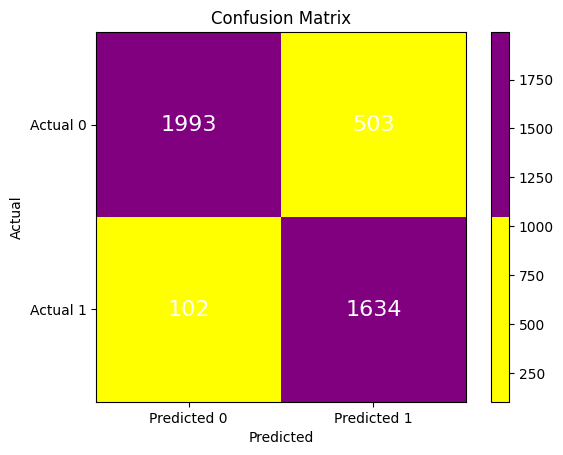

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cm = confusion_matrix(y_test, y_pred)
# Define custom colors (e.g., green and purple)
colors = ['yellow', 'purple']

# Create a colormap using custom colors
cmap = mcolors.ListedColormap(colors)

# Plot the confusion matrix heatmap
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.xticks([0, 1], ["Predicted 0", "Predicted 1"])
plt.yticks([0, 1], ["Actual 0", "Actual 1"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=16)

plt.show()

In [12]:
initial_f1 = calculate_f1(np.array(y_test), y_pred)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_test, y_pred, calculate_f1)
rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

[0.8568052930056711, 0.8589319470699431, 0.8523156899810964, 0.8549149338374291, 0.8532608695652174, 0.8624763705103969, 0.8506616257088847, 0.8532608695652174, 0.8449905482041588, 0.854678638941399, 0.8565689981096408, 0.8544423440453687, 0.8686200378071833, 0.8504253308128544, 0.8537334593572778, 0.8622400756143668, 0.8582230623818525, 0.8620037807183365, 0.8584593572778828, 0.8480623818525519, 0.8485349716446124, 0.8551512287334595, 0.8499527410207941, 0.8629489603024575, 0.8539697542533081, 0.8534971644612478, 0.854678638941399, 0.8523156899810964, 0.8608223062381852, 0.849007561436673, 0.8530245746691871, 0.8620037807183365, 0.8660207939508507, 0.8577504725897921, 0.8601134215500945, 0.8598771266540642, 0.854678638941399, 0.8525519848771267, 0.8568052930056711, 0.8608223062381852, 0.8527882797731569, 0.8572778827977315, 0.8549149338374291, 0.8674385633270322, 0.8568052930056711, 0.8582230623818525, 0.8565689981096408, 0.8523156899810964, 0.850897920604915, 0.8525519848771267, 0.86

In [13]:
print(f"PROTT5 KNN:")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - MCC: {matthews_corrcoef(y_test, y_pred)}")
print(f"  - Mean F1 ± SE F1: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")

PROTT5 KNN:
  - Accuracy: 0.8570415879017014
  - Initial F1 Score: 0.86
  - MCC: 0.7277317049631821
  - Mean F1 ± SE F1: 0.857 ± 0.0054
  - 95% CI: [0.85, 0.87]


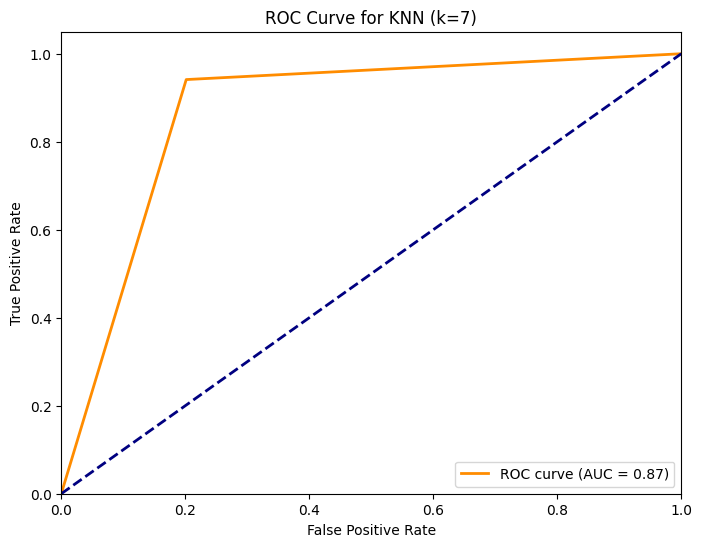

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN (k=7)')
plt.legend(loc='lower right')
plt.show()